# Rendimiento del combustible en autos comerciales.

Realizaremos un análisis de diferentes vehículos para poder realizar inferencias sobre su rendimiento de combustible, específicamente la cantidad de millas que pueden recorrer por galón de gasolina, además de las inferencias buscamos realizar un modelo que sea capaz de predecir con cierta certeza la cantidad de millas que recorre un auto con conocer cierta información de este.

Para realizar dicho estudio obtuvimos información del [UCI Machine Learning Repository](https://archive.ics.uci.edu/) específicamente de [Auto MPG](https://archive.ics.uci.edu/dataset/9/auto+mpg) de un estudio de Quinlan, R. (1993).

Dicha información cuenta con las siguientes variables:

MPG: Miles per galon, millas por galón, nuestra variable de interés.    
Cylinders: La cantidad de cilindros del auto.   
Displacement: Volumen total de aire y combustible que un auto puede desplazar en un ciclo de combustión.   
Horsepower: Caballos de fuerza, es una medida de potencia.   
Weight: Peso en libras.   
Acceleration: Aceleración.     
Model year: Año del modelo de auto.   
Origin: País de origen del auto. 1: America, 2: Europa, 3: Asia   
Car Name: Modelo del auto.   

Creo que esta información tiene potencial para generar una regresión lineal ya que cuenta con datos en su mayoría cuantitativos y cualitativos que sospecho están estrechamente relacionados con el rendimiento de combustible. Un análisis pre eliminar al observar ciertas variables me di cuenta de que un modelo lineal o cuadrático podrían describir el comportamiento.  

La base de datos tenía algunos valores de la variable de interés como NaN, se eliminaron esas filas ya que considero que cualquier manera de conseguir ese valor añadiría incertidumbre a nuestro modelo. Estaríamos construyendo nuestro modelo en terreno que no es firme.




In [1]:
import pandas as pd

# Abrimos la base de datos.
df = pd.read_csv("auto-mpg.data-original",  sep='\s+')

# Asignamos nombres a las columnas
df.columns = ["MPG", "Cylinders", "Displacement", "Horsepower", "Weight", "Acceleration", "Model_year", "Origin", "Car name"]

# Imprimimos la base de datos para visualizar nuestra información
display(df.head(3))

#Tiramos el nombre del modelo ya que es unico por cada auto y no nos aportara informacion relevante.
df = df.drop(columns=["Car name"])
print("\nDatos modificados:")
display(df.head(2))

print("Cantidad de información:",df.shape)

print("Cantidad de paises de origen", pd.Series(df["Origin"].value_counts()))


,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model_year,Origin,Car name
0,15.0,8.0,350.0,165.0,3693.0,11.5,70.0,1.0,buick skylark 320
1,18.0,8.0,318.0,150.0,3436.0,11.0,70.0,1.0,plymouth satellite
2,16.0,8.0,304.0,150.0,3433.0,12.0,70.0,1.0,amc rebel sst



Datos modificados:


,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model_year,Origin
0,15.0,8.0,350.0,165.0,3693.0,11.5,70.0,1.0
1,18.0,8.0,318.0,150.0,3436.0,11.0,70.0,1.0


Cantidad de información: (397, 8)
Cantidad de paises de origen Origin
1.0    248
3.0     79
2.0     70
Name: count, dtype: int64


Podemos observar que por el momento contamos con 397 observaciones y 8 variables para poder realizar nuestro análisis.    
  
  
Al observar la base de datos nos damos cuenta de que una de las variables, la de origen es una variable categórica, tendremos que hacer un procedimiento conocido como one hot encoding que consiste en crear variables dummies para que la información pueda utilizarse en una regresión. Dicha variable categórica contiene 248 datos del origen 1 (América), 79 datos del origen 3 (Asia) y 70 del origen 2 (Europa).


In [2]:
# Crear variable dummy
dummyOrigin = pd.get_dummies(df.Origin,drop_first=True).astype(int)
# Concatenar la variable dummy al data frame
df = pd.concat([df,dummyOrigin], axis = 1)
# Eliminar la variable Origin del data frame
df = df.drop("Origin", axis = 1)
# Imprimir las primeras 3 observaciones
display(df.head(3))

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model_year,2.0,3.0
0,15.0,8.0,350.0,165.0,3693.0,11.5,70.0,0,0
1,18.0,8.0,318.0,150.0,3436.0,11.0,70.0,0,0
2,16.0,8.0,304.0,150.0,3433.0,12.0,70.0,0,0


Podemos observar que las variables se crearon correctamente, es importante observar que ya no existe la variable origin y tampoco existe la etiqueta 1 esto es normal ya que se asume como lo "Normal" y es para evitar colinealidad, vamos a renombrar las etiquetas para poder trabajar de mejor forma.

In [3]:
df = df.rename(columns={2.0:"Europa"})
df = df.rename(columns={3.0:"Asia"})


print("Cantidad de variables:", df.shape[1])

display(df.head())

#Diferentes tipos de datos del df
print(df.dtypes)


Cantidad de variables: 9


,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model_year,Europa,Asia
0,15.0,8.0,350.0,165.0,3693.0,11.5,70.0,0,0
1,18.0,8.0,318.0,150.0,3436.0,11.0,70.0,0,0
2,16.0,8.0,304.0,150.0,3433.0,12.0,70.0,0,0
3,17.0,8.0,302.0,140.0,3449.0,10.5,70.0,0,0
4,15.0,8.0,429.0,198.0,4341.0,10.0,70.0,0,0


MPG             float64
Cylinders       float64
Displacement    float64
Horsepower      float64
Weight          float64
Acceleration    float64
Model_year      float64
Europa            int64
Asia              int64
dtype: object


Como podemos observar ya está configurado nuestro data set y ahora tenemos más variables que antes, gracias al one hot encoding.
    
Ahora vamos a realizar el método de Tukey para detectar valores atípicos.

In [4]:
import numpy as np

# Seleccionar solo las columnas numéricas
numerical_cols = df.select_dtypes(include=["float64"]).columns

# Crear un diccionario para almacenar los outliers de cada variable
outliers_dict = {}

# Calcular outliers para cada columna numérica
for col in numerical_cols:
    q1 = df[col].quantile(0.25)  # Cuartil 1
    q3 = df[col].quantile(0.75)  # Cuartil 3
    iqr = q3 - q1  # Rango intercuartil
    li = q1 - (3 * iqr)  # Límite inferior
    ls = q3 + (3 * iqr)  # Límite superior
    
    # Identificar los índices de los outliers
    outliers = np.where((df[col] <= li) | (df[col] >= ls))[0]
    
    # Guardar en el diccionario si hay outliers
    if len(outliers) > 0:
        outliers_dict[col] = df.iloc[outliers]

# Imprimir resultados
for col, outliers in outliers_dict.items():
    print(f"\nOutliers en la columna: {col}")
    print(outliers)

Al realizar el análisis de Tukey nos damos cuenta de que en ninguna de las variables numéricas existe algún dato atípico, nos damos cuenta ya que nuestro código no imprime ningún valor, el código anterior está diseñado para imprimir los valores atípicos, en caso de que no existan, no imprime nada.   
    
Ahora vamos a realizar un mapa de calor en el cual se muestra la correlación de Pearson entre las variables para poder evitar que exista colinealidad entre las variables, vamos a observar si ocurre este fenómeno en dicho mapa y en caso de que lo haga tomar una decisión al respecto.   


Mayor correlación entre: Cylinders y Displacement
Valor de la correlación: 0.9507183222728156


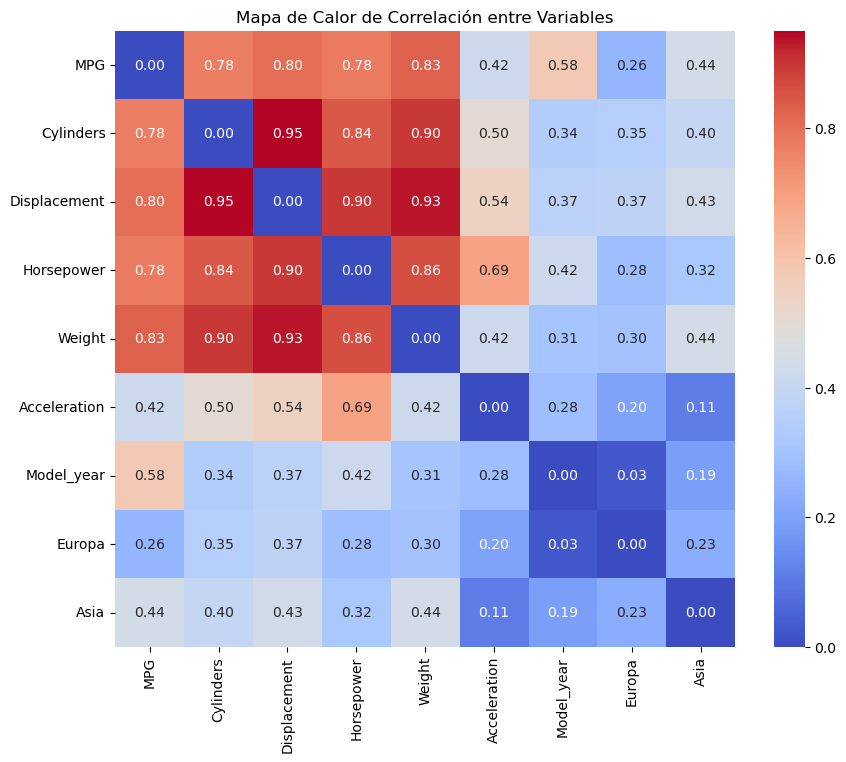

In [5]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

# Calcular la matriz de correlación con nombres de columnas
cor = df.corr().abs()  # Usar df.corr() para mantener los nombres de las columnas

# Llenar la diagonal con ceros para evitar autovalores de 1
np.fill_diagonal(cor.values, 0)

# Obtener los índices (i, j) de la correlación máxima
i, j = np.unravel_index(cor.values.argmax(), cor.shape)

# Imprimir los nombres de las variables con mayor correlación
print(f"Mayor correlación entre: {df.columns[i]} y {df.columns[j]}")
print(f"Valor de la correlación: {cor.iloc[i, j]}")

# Graficar el heatmap con nombres de variables
plt.figure(figsize=(10, 8))
sns.heatmap(cor, annot=True, fmt=".2f", cmap="coolwarm", xticklabels=df.columns, yticklabels=df.columns)
plt.title("Mapa de Calor de Correlación entre Variables")
plt.show()

Podemos observar que existe una correlación del 95% entre las variables de cilindros y desplazamiento, algo de esperarse ya que el segundo aumenta con la cantidad de cilindros, por lo cual eliminaremos alguna de las dos variables para evitar entorpecer el modelo por colinealidad, conservaremos desplazamiento porque es la que mayor correlación tiene con nuestra variable de interés.      
     
Otra variable relacionada es el peso con el desplazamiento y aunque podría sonar lógico, más peso más volumen de combustible necesario, no necesariamente están relacionados, por lo cual, aunque su relación es alta conservare ambas.    
     
También existe una alta relación entre los caballos de fuerza y el desplazamiento, eliminaremos los caballos de fuerza debido a que creo que, si es relevante su relación, si hay más desplazamiento es natural que haya más caballos de fuerza, conservare desplazamiento ya que se relaciona más con la variable de interés.     
     
Además de esto añadiré una interacción entre desplazamiento y peso, además de una de peso-aceleración, ya que creo que pueden ser relevantes.


In [6]:
# Dejamos las variables con colinearidad
df = df.drop(columns="Cylinders")
df = df.drop(columns="Horsepower")

display(df.head(3))

from sklearn.model_selection import train_test_split

# Partimos los datos en entrenamiento y prueba 80-20
x_train, x_test, y_train, y_test = train_test_split(df.drop(columns="MPG"), df.MPG, train_size=0.8, random_state=23)
print(x_train)
print(y_train)

,MPG,Displacement,Weight,Acceleration,Model_year,Europa,Asia
0,15.0,350.0,3693.0,11.5,70.0,0,0
1,18.0,318.0,3436.0,11.0,70.0,0,0
2,16.0,304.0,3433.0,12.0,70.0,0,0


     Displacement  Weight  Acceleration  Model_year  Europa  Asia
351          98.0  2380.0          20.7        81.0       0     0
203          85.0  1990.0          17.0        76.0       0     1
188         304.0  3962.0          13.9        76.0       0     0
366         112.0  2605.0          19.6        82.0       0     0
46          250.0  3282.0          15.0        71.0       0     0
..            ...     ...           ...         ...     ...   ...
237          98.0  2075.0          15.9        77.0       0     0
31           98.0  2046.0          19.0        71.0       0     0
40          318.0  4096.0          13.0        71.0       0     0
230         400.0  4325.0          12.2        77.0       0     0
83           97.0  2100.0          16.5        72.0       0     1

[317 rows x 6 columns]
351    29.9
203    32.0
188    15.5
366    28.0
46     19.0
       ... 
237    33.5
31     25.0
40     14.0
230    15.5
83     27.0
Name: MPG, Length: 317, dtype: float64


In [7]:
#Agregamos las interacciones en el entrenamiento y la prueba
x_train.insert(2,"Displacement_Weight", x_train.Displacement*x_train.Weight)
x_train.insert(4,"Acceleration_Weight", x_train.Acceleration*x_train.Weight)

x_test.insert(2,"Displacement_Weight", x_test.Displacement*x_test.Weight)
x_test.insert(4,"Acceleration_Weight", x_test.Acceleration*x_test.Weight)

# Imprimir primeras 5 observaciones de X_train
display(x_train.head())
# Imprimir primeras 5 observaciones de X_test
display(x_test.head())

,Displacement,Weight,Displacement_Weight,Acceleration,Acceleration_Weight,Model_year,Europa,Asia
351,98.0,2380.0,233240.0,20.7,49266.0,81.0,0,0
203,85.0,1990.0,169150.0,17.0,33830.0,76.0,0,1
188,304.0,3962.0,1204448.0,13.9,55071.8,76.0,0,0
366,112.0,2605.0,291760.0,19.6,51058.0,82.0,0,0
46,250.0,3282.0,820500.0,15.0,49230.0,71.0,0,0


,Displacement,Weight,Displacement_Weight,Acceleration,Acceleration_Weight,Model_year,Europa,Asia
133,258.0,3632.0,937056.0,18.0,65376.0,74.0,0,0
298,141.0,3190.0,449790.0,24.8,79112.0,79.0,1,0
167,140.0,2639.0,369460.0,17.0,44863.0,75.0,0,0
333,70.0,2420.0,169400.0,12.5,30250.0,80.0,0,1
239,97.0,2190.0,212430.0,14.1,30879.0,77.0,1,0


Llevaremos a cabo una selección de características mixta, una hacia adelante y después una hacia atrás para poder tener más confianza y eficiencia en nuestros resultados. Es beneficioso tener un modelo con la menor cantidad de variables posible, beneficia a la interpretabilidad y para evitar el overfitting.

In [8]:
from sklearn.linear_model import LinearRegression
from mlxtend.feature_selection import SequentialFeatureSelector as SFS

# Creamos el modelo de regresion lineal
lr = LinearRegression()

# Vaciamos las caracteristicas del modelo de sequential future selector
sfs = SFS(lr, k_features= (2,8), forward=True, scoring= 'r2', cv = 10 )

# Ejecutamos el selector 
sfs.fit(x_train,y_train)

# Obtenemos los nombres e indices de las variables selecionadas
featuresIndx = list(sfs.k_feature_idx_)
features = list(sfs.k_feature_names_)
print("Features(Variables selecionadas): \n", features)



# Obtenemos R^2
from sklearn.metrics import r2_score

x_train_s1 = x_train[features]
x_test_s1 = x_test[features]

lr.fit(x_train_s1,y_train)

yhat = lr.predict(x_test_s1)

r2 = r2_score(y_test , yhat)

print("R^2 =", r2)



Features(Variables selecionadas): 
 ['Displacement', 'Weight', 'Displacement_Weight', 'Acceleration', 'Model_year', 'Europa', 'Asia']
R^2 = 0.8507567994133431


Aquí obtuvimos una R^2 de 0.85, quiere decir que con las variables que obtuvimos de nuestra selección hacia adelante para una regresión lineal describe el 0.85% del comportamiento que buscamos explicar. Ahora compararemos con la selección mixta, es decir ahora hacia atrás y escogeremos un modelo.

In [9]:
#Creamos el modelo de regresion lineal
lr1 = LinearRegression()

# Vaciamos las caracteristicas del modelo de sequential future selector
sfs1 = SFS(lr, k_features= (2,5), forward=False, scoring= 'r2', cv = 10 )

# Ejecutamos el selector 
sfs1.fit(x_train_s1,y_train)

# Obtenemos los nombres e indices de las variables selecionadas
featuresIndx1 = list(sfs1.k_feature_idx_)
features1 = list(sfs1.k_feature_names_)
print("Features(Variables selecionadas): \n", features1)


# Obtenemos R^2
x_train_s2 = x_train[features1]
x_test_s2 = x_test[features1]

lr1.fit(x_train_s2,y_train)

yhat1 = lr1.predict(x_test_s2)

r2_mixto = r2_score(y_test,yhat1)

print("R^2 de la selección mixta de características =", r2_mixto)

Features(Variables selecionadas): 
 ['Displacement', 'Weight', 'Displacement_Weight', 'Acceleration', 'Model_year']
R^2 de la selección mixta de características = 0.8507668467068836


Escogeré como mejor modelo el modelo mixto ya que mantiene una R^2 bastante similar, pero reduce el número de variables, algo que le añade valor a nuestro modelo.

Ahora entrenaremos un modelo de regresión lineal, uno múltiple, uno simple y uno cuadrático, escogimos esos modelos por observaciones a la gráfica de Displacement_Weight vs y_train. 

In [10]:
import statsmodels.api as sm

# Mantenemos las variables seleccionadas por el metodo mixto
x_train = x_train.drop(columns=["Acceleration_Weight", "Europa", "Asia"])
x_test = x_test.drop(columns=["Acceleration_Weight", "Europa", "Asia"])

# Entrenamos el modelo
LinearMultipleModel = sm.OLS(y_train, sm.add_constant(x_train))
LinearMultipleResults = LinearMultipleModel.fit()

print(LinearMultipleResults.summary())

                            OLS Regression Results                            
Dep. Variable:                    MPG   R-squared:                       0.856
Model:                            OLS   Adj. R-squared:                  0.853
Method:                 Least Squares   F-statistic:                     368.4
Date:                Wed, 19 Feb 2025   Prob (F-statistic):          2.58e-128
Time:                        23:05:19   Log-Likelihood:                -796.47
No. Observations:                 317   AIC:                             1605.
Df Residuals:                     311   BIC:                             1627.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                  -9.6216    

Podemos observar que el modelo describe alrededor del 85.3% del comportamiento de la variable de nuestro interés y que existe una muy alta probabilidad de que al menos una de las variables esté relacionada con la variable de interés.   
Podría afirmar que para todas las variables que utilizamos que existe al menos el 95% de confianza de que existe una relación con dicha variable y la variable de interés MPG.   
Por cada unidad que aumenta el Displacement y las demás variables permanecen fijas se pierde un rendimiento de 0.0769 millas por galón.   
Por cada unidad que aumenta el Weight y las demás variables permanecen fijas se pierde un rendimiento de 0.0117 millas por galón.   
Por cada unidad que aumenta el Displacement_Weight y las demás variables permanecen fijas se pierde un rendimiento de 0.00002402 millas por galón.   
Por cada unidad que aumenta la Acceleration y las demás variables permanecen fijas se gana un rendimiento de 0.2297 millas por galón.    
Por cada año que es manuevo el Model_year y las demás variables permanecen fijas aumenta un rendimiento de 0.8345 millas por galón.

In [11]:
# RSE (error estándar de los coeficientes)
print("Errores estándar (RSE) de los coeficientes:")
print(LinearMultipleResults.bse)  # Devuelve los errores estándar de cada coeficiente

# Intervalos de confianza de los coeficientes
print("\nIntervalos de confianza de los coeficientes:")
print(LinearMultipleResults.conf_int())  # Devuelve los intervalos de confianza de 95% para cada coeficiente

Errores estándar (RSE) de los coeficientes:
const                  4.005088
Displacement           0.009478
Weight                 0.000754
Displacement_Weight    0.000002
Acceleration           0.078663
Model_year             0.049909
dtype: float64

Intervalos de confianza de los coeficientes:
                             0         1
const               -17.502130 -1.741140
Displacement         -0.095569 -0.058272
Weight               -0.013136 -0.010168
Displacement_Weight   0.000019  0.000029
Acceleration          0.074941  0.384499
Model_year            0.736251  0.932654


Displacement: El error estándar de Displacement es 0.009478.   
Weight: El error estándar de Weight es 0.000754.   
Displacement_Weight: El error estándar de Displacement_Weight es 0.000022.   
Acceleration: El error estándar de Acceleration es 0.078635.   
Model_year: El error estándar de Model_year es 0.049909.    
    
Podemos decir con un 95% de confianza que por cada unidad que aumenta el Displacement, la cantidad de millas por galón se ve reducida entre 0.095569 y 0.058272.   
Podemos decir con un 95% de confianza que por cada unidad que aumenta el Weight, la cantidad de millas por galón se ve reducida entre 0.013136 y 0.010618.   
Podemos decir con un 95% de confianza que por cada unidad que aumenta Displacement_Weight, la cantidad de millas por galón se ve aumentada entre 0.000019 y 0.000020.    
Podemos decir con un 95% de confianza que por cada unidad que aumenta la Acceleration, la cantidad de millas por galón se ve aumentada entre 0.074941 y 0.384499.   
Podemos decir con un 95% de confianza que por cada unidad que aumenta el Model_year, la cantidad de millas por galón se ve aumentada entre 0.736251 y 0.932654.   

Seguimos los procedimientos adecuados para obtener este tipo de resultados, revisamos los datos para encontrar huecos e inconsistencias, además evitamos la fuga de datos, y dividimos el data set para evitar el overfitting.    
    
Posteriormente calcularemos la R^2 con los datos de prueba.

RSE de la regresión lineal multilple en datos de prueba = 3.0265474026174046
R^2 de la regresión lineal multilple en datos de prueba = 0.8507668467072269


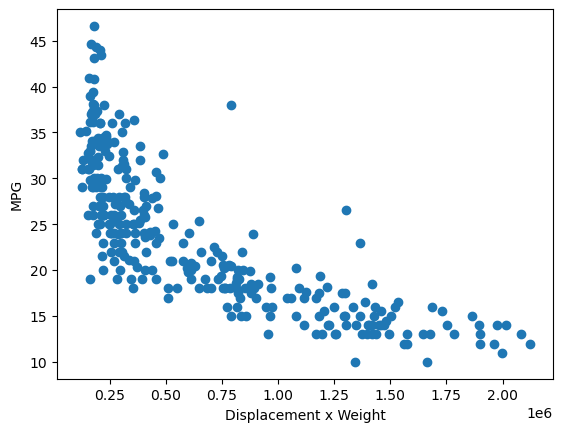

In [12]:
plt.scatter(x_train.Displacement_Weight,y_train)
plt.xlabel("Displacement x Weight")
plt.ylabel("MPG")

yhat_Multiple = LinearMultipleResults.predict(sm.add_constant(x_test))

# Calcula el RSS de validación
RSSTest = sum((y_test-yhat_Multiple)**2)
# Calcula el TSS de validación
TSSTest = sum((y_test-np.mean(y_test))**2)
# Define el valor de n para los datos de prueba
nTest = x_test.shape[0]
# Define el valor de m para los datos de prueba
mTest = x_test.shape[1]
# Calcula el RSE de validación
RSETest = np.sqrt(RSSTest/(nTest-mTest-1))
# Calcula el R^2 de validación
R2Test = 1 - RSSTest/TSSTest
# Imprime el RSE
print("RSE de la regresión lineal multilple en datos de prueba =", RSETest)
# Imprime el R^2
print("R^2 de la regresión lineal multilple en datos de prueba =", R2Test)

Podemos observar unos resultados bastante parecidos a los obtenidos en los datos de entrenamiento, lo que nos sugiere que nuestro modelo no es tan propenso al overfitting.  

Ahora entrenaremos el modelo de regresión lineal simple.

                            OLS Regression Results                            
Dep. Variable:                    MPG   R-squared:                       0.620
Model:                            OLS   Adj. R-squared:                  0.619
Method:                 Least Squares   F-statistic:                     514.5
Date:                Wed, 19 Feb 2025   Prob (F-statistic):           3.38e-68
Time:                        23:05:20   Log-Likelihood:                -949.67
No. Observations:                 317   AIC:                             1903.
Df Residuals:                     315   BIC:                             1911.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                  31.6899    

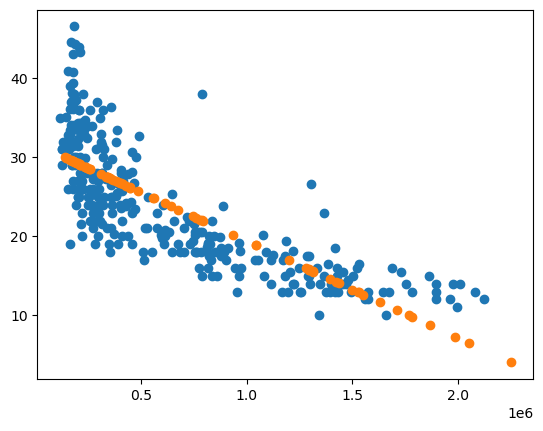

In [13]:
import statsmodels.api as sm

#Entrenamos el modelo
LinearModel = sm.OLS(y_train, sm.add_constant(x_train.Displacement_Weight))
LinearResults = LinearModel.fit()

print(LinearResults.summary())

yhat_Lineal = LinearResults.predict(sm.add_constant(x_test.Displacement_Weight))

#Graficamos el modelo
plt.scatter(x_train.Displacement_Weight,y_train)
plt.scatter(x_test.Displacement_Weight, yhat_Lineal)


In [14]:
yhat_Lineal = LinearResults.predict(sm.add_constant(x_test["Displacement_Weight"]))

# Calcular la Suma de Cuadrados del Residuo (RSS)
RSS_lineal = np.sum((y_test - yhat_Lineal) ** 2)  

# Número de observaciones en el conjunto de prueba
n_lineal = len(y_test)

# Calcular el Error Estándar de la Regresión (RSE)
RSE_lineal = np.sqrt(RSS_lineal / (n_lineal - 2))  

# Calcular la Suma de Cuadrados Total (TSS)
TSS_sqr = np.sum((y_test - np.mean(y_test)) ** 2)

# Calcular el Coeficiente de Determinación (R²)
R2_lineal = 1 - (RSS_lineal / TSS_sqr)

# Imprimir resultados
print("\nRSE de la regresión lineal simple en datos de prueba:", RSE_lineal)
print("R^2 de la regresión lineal simple en datos de prueba:", R2_lineal)


RSE de la regresión lineal simple en datos de prueba: 4.609935991350929
R^2 de la regresión lineal simple en datos de prueba: 0.6350586884144109



Al observar el sumario de la regresión lineal simple nos podemos dar cuenta fácilmente de que el modelo describe el 62% del comportamiento de la variable de interés y podemos afirmar con un 95% de confianza que existe una relación entre la variable Displacement_Weight y la variable de interés MPG.

Al observar el modelo nos damos cuenta de que sugiere que por cada unidad de Displacement_Weight, es decir cada que aumenta una unidad del producto de desplazamiento por el peso del vehículo la cantidad de millas por galón que un auto puede recorrer se ve reducido 0.00001227 millas.

Podemos observar que se mantiene un R^2 bastante estable e incluso más alto que en los datos de entrenamiento, esto me sugiere que el sistema no está cerca del overfitting.

Se utilizo el modelo lineal porque se sugirió este modelo, se siguieron los procedimientos estándar para escoger los mejores datos y se evitó la fuga de datos.



Ahora generaremos una regresión cuadrática ya que es el modelo que creo que más se ajusta a la forma de la gráfica generada anteriormente.

In [15]:
import statsmodels.api as sm

#Los cambios son necesarios para que la función pueda usar los datos y compile el código.

#Cambiamos la forma de los datos a un array más amplio
xtemp_train = x_train.Displacement_Weight.values.reshape(-1,1)
xtemp_test = x_test.Displacement_Weight.values.reshape(-1,1)

from sklearn.preprocessing import PolynomialFeatures

#Generamos polinomiales
polyq_train = PolynomialFeatures(degree=2).fit(xtemp_train)
polyq_test = PolynomialFeatures(degree=2).fit(xtemp_test)

#Los tranformamos a un data frame
xq_train = pd.DataFrame(polyq_train.transform(xtemp_train))
xq_test = pd.DataFrame(polyq_test.transform(xtemp_test))

#Entrenamos el modelo
mq = sm.OLS(list(y_train),xq_train).fit()

print(mq.summary())


                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.692
Model:                            OLS   Adj. R-squared:                  0.690
Method:                 Least Squares   F-statistic:                     352.0
Date:                Wed, 19 Feb 2025   Prob (F-statistic):           6.25e-81
Time:                        23:05:20   Log-Likelihood:                -916.68
No. Observations:                 317   AIC:                             1839.
Df Residuals:                     314   BIC:                             1851.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
0             35.8474      0.630     56.910      0.0

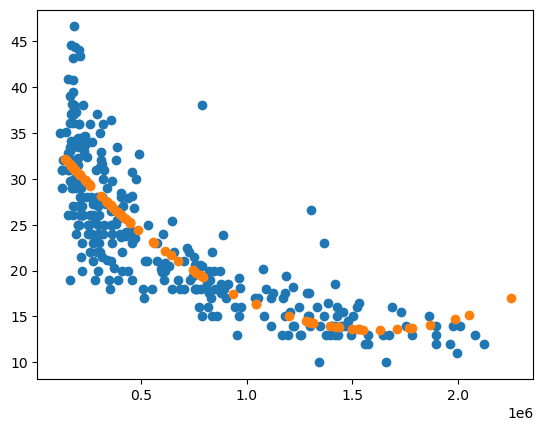

In [16]:

# Hacer predicciones en los datos de prueba
yhat_sqr = mq.predict(xq_test)

plt.scatter(x_train.Displacement_Weight,y_train)
plt.scatter(x_test.Displacement_Weight, yhat_sqr)

Nos podemos dar cuenta de que el modelo describe el 69% del comportamiento de la variable de interés, MPG.   
Podemos observar que el valor p del estadístico F es extremadamente bajo lo que sugiere que al menos una de las variables contenidas en el modelo se relaciona con la variable de salida.  
Podemos decir con el 95% de confianza de que el coeficiente lineal tiene relación con la variable de salida MPG.   
Podemos decir con el 95% de confianza de que el coeficiente cuadrático tiene relación con la variable de salida MPG. 
Dichas afirmaciones se sustentan en el valor p de las betas.  


In [17]:
# RSE (error estándar de los coeficientes)
print("Errores estándar (RSE) de los coeficientes:")
print(mq.bse)  # Devuelve los errores estándar de cada coeficiente

# Intervalos de confianza de los coeficientes
print("\nIntervalos de confianza de los coeficientes:")
print(mq.conf_int())  # Devuelve los intervalos de confianza de 95% para cada coeficiente

Errores estándar (RSE) de los coeficientes:
0    6.299002e-01
1    1.865804e-06
2    1.003000e-12
dtype: float64

Intervalos de confianza de los coeficientes:
              0             1
0  3.460807e+01  3.708678e+01
1 -3.129304e-05 -2.395092e-05
2  6.574870e-12  1.052177e-11


Podemos decir con un 95% de confianza que por cada unidad del producto de las variables de Displacement y Weight las millas por galón que puede recorrer el auto se ven reducidas entre 0.0000239 y 0.0000312 millas.   
Podemos decir con un 95% de confianza que por cada unidad cuadrática del producto de las variables de Displacement y Weight las millas por galón que puede recorrer el auto se ven aumentadas entre 6.574870e-12 y 1.052177e-11 millas.   


In [18]:


# Calcular la Suma de Cuadrados del Residuo (RSS)
RSS_sqr = np.sum((y_test - yhat_sqr) ** 2)  

# Número de observaciones en el conjunto de prueba
n_sqr = len(y_test)

# Calcular el Error Estándar de la Regresión (RSE)
RSE_sqr = np.sqrt(RSS_sqr / (n_sqr - 2))  

# Calcular la Suma de Cuadrados Total (TSS)
TSS_sqr = np.sum((y_test - np.mean(y_test)) ** 2)

# Calcular el Coeficiente de Determinación (R²)
R2_sqr = 1 - (RSS_sqr / TSS_sqr)

# Imprimir resultados
print("RSE de la regresión lineal simple en datos de prueba:", RSE_sqr)
print("R^2 de la regresión lineal simple en datos de prueba:", R2_sqr)

RSE de la regresión lineal simple en datos de prueba: 5.82520962731678
R^2 de la regresión lineal simple en datos de prueba: 0.41728478862984


Podemos observar que existe una diferencia bastante considerable en los R^2 del modelo del entrenamiento y el entrenamiento de prueba, lo que podría sugerir que nos acercamos a un overfitting.

Habiendo realizado nuestros modelos de predicción escogeremos el modelo de regresión lineal múltiple para realizar un análisis de inferencia, debido a que obtuvimos los mejores resultados, tanto en métricas de error, de comportamiento y de robustes en cuanto a overfitting. Para esto utilizaremos todo el data set, únicamente con las variables seleccionadas para entrenar el modelo.

In [19]:
# Concatenar X_train y X_test en un solo DataFrame
x_total = pd.concat([x_train, x_test], axis=0).reset_index(drop=True)

# Concatenar y_train y y_test en un solo DataFrame
y_total = pd.concat([y_train, y_test], axis=0).reset_index(drop=True)

# Entrenamos el modelo
LMM_all = sm.OLS(y_total, sm.add_constant(x_total))
LMM_all_results = LMM_all.fit()

print(LMM_all_results.summary())


                            OLS Regression Results                            
Dep. Variable:                    MPG   R-squared:                       0.856
Model:                            OLS   Adj. R-squared:                  0.854
Method:                 Least Squares   F-statistic:                     465.4
Date:                Wed, 19 Feb 2025   Prob (F-statistic):          3.87e-162
Time:                        23:05:21   Log-Likelihood:                -994.48
No. Observations:                 397   AIC:                             2001.
Df Residuals:                     391   BIC:                             2025.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                  -8.3358    

Ahora podemos realizar afirmaciones con nuestro analisis de inferencia.

Podemos observar que el modelo describe alrededor del 85.4% del comportamiento de la variable de nuestro interés y que existe una muy alta probabilidad de que al menos una de las variables esté relacionada con la variable de interés.   
Podría afirmar que para todas las variables que utilizamos que existe al menos el 95% de confianza de que existe una relación con dicha variable y la variable de interés MPG.   
Por cada unidad que aumenta el Displacement y las demás variables permanecen fijas se pierde un rendimiento de 0.0754 millas por galón.   
Por cada unidad que aumenta el Weight y las demás variables permanecen fijas se pierde un rendimiento de 0.0115 millas por galón.   
Por cada unidad que aumenta el Displacement_Weight y las demás variables permanecen fijas se pierde un rendimiento de 0.00002348 millas por galón.   
Por cada unidad que aumenta la Acceleration y las demás variables permanecen fijas se gana un rendimiento de 0.1919 millas por galón.    
Por cada año que es manuevo el Model_year y las demás variables permanecen fijas aumenta un rendimiento de 0.8177 millas por galón.    


In [20]:
# RSE (error estándar de los coeficientes)
print("Errores estándar (RSE) de los coeficientes:")
print(LMM_all_results.bse)  # Devuelve los errores estándar de cada coeficiente

# Intervalos de confianza de los coeficientes
print("\nIntervalos de confianza de los coeficientes:")
print(LMM_all_results.conf_int())  # Devuelve los intervalos de confianza de 95% para cada coeficiente


Errores estándar (RSE) de los coeficientes:
const                  3.598977
Displacement           0.008308
Weight                 0.000653
Displacement_Weight    0.000002
Acceleration           0.068726
Model_year             0.044448
dtype: float64

Intervalos de confianza de los coeficientes:
                             0         1
const               -15.411542 -1.260005
Displacement         -0.091779 -0.059109
Weight               -0.012775 -0.010207
Displacement_Weight   0.000019  0.000028
Acceleration          0.056822  0.327060
Model_year            0.730347  0.905121


Displacement: El error estándar de Displacement es 0.008308.   
Weight: El error estándar de Weight es 0.000653.   
Displacement_Weight: El error estándar de Displacement_Weight es 0.000002.   
Acceleration: El error estándar de Acceleration es 0.068726.   
Model_year: El error estándar de Model_year es 0.044448.    
    
Podemos decir con un 95% de confianza que por cada unidad que aumenta el Displacement, la cantidad de millas por galón se ve reducida entre 0.091779 y 0.059109.   
Podemos decir con un 95% de confianza que por cada unidad que aumenta el Weight, la cantidad de millas por galón se ve reducida entre 0.012775 y 0.010207.   
Podemos decir con un 95% de confianza que por cada unidad que aumenta Displacement_Weight, la cantidad de millas por galón se ve aumentada entre 0.000019 y 0.000028.    
Podemos decir con un 95% de confianza que por cada unidad que aumenta la Acceleration, la cantidad de millas por galón se ve aumentada entre 0.056822 y 0.327060.   
Podemos decir con un 95% de confianza que por cada unidad que aumenta el Model_year, la cantidad de millas por galón se ve aumentada entre 0.730347 y 0.905121.   


Con esto damos por terminado el nuestro análisis, cumpliendo nuestro objetivo de obtener un modelo que sea capaz de predecir el MPG, la variable de interés, en este caso un error menor a 3.5 galones según nuestra validación en los datos de prueba y además hemos sido capaces de realizar inferencias sobre el data set.

Agradezco al lector por su tiempo:
-Armando Rdz


Referencias:

Quinlan, R. (1993). Auto MPG [Dataset]. UCI Machine Learning Repository. https://doi.org/10.24432/C5859H.